# Feature Map - SHAP

Below is the code used for analysing SHAP values for a feature map.

In [52]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [ ]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import os

# import data class
from utilities.dataset_utils import DiabetesData

# explainability imports
# feature map SHAP
from shap import KernelExplainer
from shap import Explanation
from shap.plots import waterfall

#state fidelity
from qiskit.quantum_info import state_fidelity

# sklearn metrics
from sklearn.metrics import pairwise_distances_argmin_min

# qiskit imports
# feature map
from qiskit.circuit.library import zz_feature_map

# simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

Dataset loading - change code hear to analyze different dataset

**N.B.** works only for binary classification datasets

In [54]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', 'utilities', 'diabetes.csv')
# load dataset class
dataset = DiabetesData(path)

In [55]:
# list of feature names
feature_names = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
]

Ranged preprocessing used between (-$\pi$, $\pi$) to allow full exploration of the bloch sphere.

In [56]:
# get data
X_train, X_test, y_train, y_test = dataset.preprocess_data_ranged()

In [57]:
# setup backend simulator
backend = AerSimulator()
backend.set_options(max_parallel_threads=os.cpu_count(), method='statevector')

In [58]:
# sampler
sampler = Sampler.from_backend(backend)

### Feature Map Explainability

Feature map implementation - change hear to analyze different feature map

In [59]:
# generate feature map used
feature_map = zz_feature_map(feature_dimension=dataset.get_num_features(), reps=4, entanglement='full')

```python
get_quantum_state
```
This function assigns the parameters of the feature map to that of the input classical data vector. It saves the quantum statevector when this circuit is executed.


In [ ]:
# function to get quantum state
def get_quantum_state(x):
    """
    Gets quantum state of a given data point
    """
    # copy circuit
    qc = feature_map.copy()
    
    # param dict
    params = dict(zip(qc.parameters, x))
    
    # assign params to circuit
    qc = qc.assign_parameters(params)
    
    # save statevector
    qc.save_statevector()
    
    # Run on statevector simulator
    result = backend.run(qc).result()
    return result.get_statevector()

```python
state_similarity
```
Measures the state fidelity between two quantum states. Fidelity is expressed as:
$$F=| \langle \psi | \phi \rangle |^2 $$

where $|\psi\rangle$ is the actual state and $|\phi\rangle$ is the target state. A fidelity of 1 indicates identical states while 0 indicates orthogonal states (different).

In [ ]:
# function to calculate fidelity between two data points
def state_similarity(x1, x2):
    """
    Measures similarity between two states
    """
    # get quantum states for 2 data points
    state1 = get_quantum_state(x1)
    state2 = get_quantum_state(x2)
    
    # calculate state fidelity
    fidelity = np.abs(state_fidelity(state1, state2))**2
    return fidelity

```python
quantum_state_encoding_shap
```
For a given sample, it calculates its quantum state similarity with perturbed versions of the sample (mixing in features from the background data). The shap values given shows what features dominate the quantum encoding process. A high expected value would mean the feature map is creating similar states, but due to this being low, this shows that the feature map is creating highly orthogonal states (no overlap). The limited range of shap values also show that no one feature is dominating the quantum encoding process.

In [ ]:
def quantum_state_encoding_shap(feature_map, x_sample, background_data, feature_names=None):
    """
    Calculate SHAP for feature map to explain how different features contribute to the quantum state representation
    
    Args:
        feature_map: Feature map circuit from zz_feature_map
        x_sample: Data point to explain
        background_data: Background dataset for reference
        feature_names: Names of the features
    """
    
    explainer = KernelExplainer(
        model=lambda x: np.array([state_similarity(x_i, x_sample) for x_i in x]), 
        data=background_data
    )
    
    # calculate shap values from explainer
    shap_values = explainer.shap_values(x_sample.reshape(1, -1))
    
    # normalise shap values
    abs_values = np.abs(shap_values[0])
    total = np.sum(abs_values)
    normalised_values = shap_values[0] / total if total > 0 else shap_values[0]
    
    plt.figure(figsize=(10, 6))
    
    explanation = Explanation(
        values=normalised_values,
        base_values=explainer.expected_value,
        data=x_sample,
        feature_names=feature_names
    )
    print(f"Expected Value: {explainer.expected_value}")
    waterfall(explanation, show=False)
    
    plt.title('Feature Importance (SHAP) for Quantum Feature Encoding')
    plt.tight_layout()
    plt.show()
    
    return shap_values

  0%|          | 0/1 [00:00<?, ?it/s]

Pregnancies: 13.88%
Glucose: 14.07%
BloodPressure: 14.22%
SkinThickness: 9.04%
Insulin: 7.73%
BMI: 14.02%
DiabetesPedigreeFunction: 12.95%
Age: 14.08%
Expected Value: 5.0856781698918664e-05


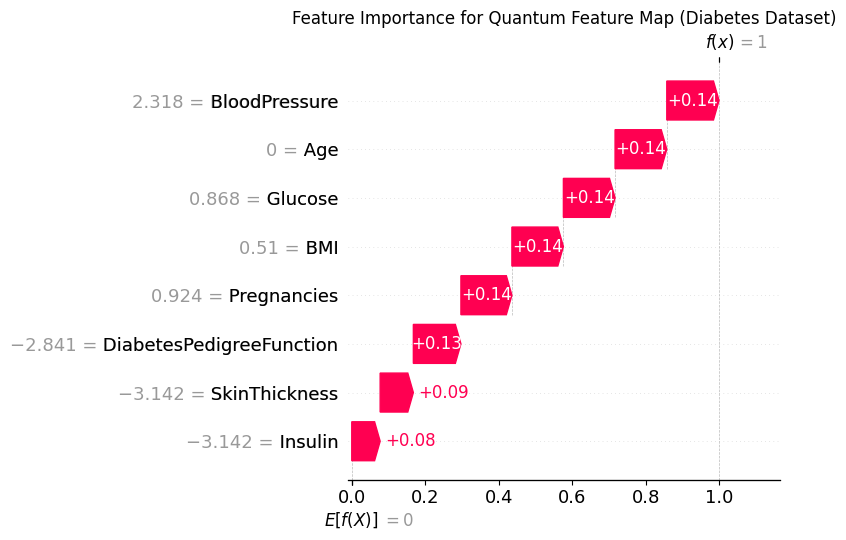

In [ ]:
# select a sample to explain
sample_idx = 150
x_sample = X_test[sample_idx]
true_label = y_test[sample_idx]

# subset of training data as background
background_data = X_train[200:300]

# calculate SHAP values for the feature map
shap_values = quantum_state_encoding_shap(
    feature_map=feature_map,
    x_sample=x_sample,
    background_data=background_data,
    feature_names=feature_names
)

As all the values are positive, the quantum encoding process is emphasizing similarities across the data, meaning no single feature is biasing the output toward greater class separation.

For further analysis, a class based SHAP analysis was implemented:

In [ ]:
# separate data by class
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

X_class_0 = X_train[class_0_indices]
X_class_1 = X_train[class_1_indices]

In [ ]:
# find most central sample in each class
central_idx_0 = pairwise_distances_argmin_min(np.mean(X_class_0, axis=0).reshape(1, -1), X_class_0)[0][0]
central_idx_1 = pairwise_distances_argmin_min(np.mean(X_class_1, axis=0).reshape(1, -1), X_class_1)[0][0]

reference_class_0 = X_class_0[central_idx_0]  # actual data point
reference_class_1 = X_class_1[central_idx_1]  # actual data point

```python
class_separation
```
Calculates how similar a quantum state of a given data point is to the quantum state of one class vs another
1) Calculates fidelity between quantum state of sample and reference quantum state for class 0
2) Calculates fidelity between quantum state of sample and reference quantum state for class 1

In [ ]:
def class_separation(x):
    """
    Returns how much more similar a point is to class 0 vs class 1 using log ratio
    """
    # calculate similarity to each class
    similarity_to_class_0 = state_similarity(x, reference_class_0)
    similarity_to_class_1 = state_similarity(x, reference_class_1)
    
    # log ratio
    epsilon = 1e-10 # avoid 0 errors
    if similarity_to_class_0 < epsilon or similarity_to_class_1 < epsilon:
        # if similarity is extremely small, return 0
        return 0
    
    # log ratio (positive means more similar to class 0/non-diabetic)
    return np.log10((similarity_to_class_0 + epsilon) / (similarity_to_class_1 + epsilon))

```python
class_separation_shap
```
Based on the 'most representative' (central) sample of each class, the function uses SHAP values to express how each feature contributes to shifting the quantum states closeness towards one class or the other. The waterfall graphs represent what features are most influential in making the encoded quantum state resemble that of diabetic or non-diabetic samples.

In [ ]:
def class_separation_shap(feature_map, X_train, y_train, X_test, y_test, backend, feature_names=None):
    """
    Calculate SHAP values that show how features contribute to quantum state class separation
    
    Args:
        feature_map: Feature map circuit from zz_feature_map
        X_train: Training data
        y_train: Training labels
        X_test: Test data
        y_test: Test labels
        backend: Quantum backend for simulation
        feature_names: Names of the features
    """
    
    # create stratified background data (equal numbers from each class)
    n_samples = min(50, min(len(X_class_0), len(X_class_1)))
    
    np.random.seed(42)  # for reproducibility
    bg_indices_0 = np.random.choice(len(X_class_0), n_samples, replace=False)
    bg_indices_1 = np.random.choice(len(X_class_1), n_samples, replace=False)
    
    background_data = np.vstack([X_class_0[bg_indices_0], X_class_1[bg_indices_1]])
    
    # SHAP explainer with separation function and identity link
    explainer = KernelExplainer(
        model=lambda x: np.array([class_separation(x_i) for x_i in x]),
        data=background_data,
        link="identity"
    )
    
    print(f"Expected Value: {explainer.expected_value}")
    
    # test samples from each class
    if np.any(y_test == 0) and np.any(y_test == 1):
        test_sample_class_0 = X_test[y_test == 0][0]
        test_sample_class_1 = X_test[y_test == 1][0]
    else:
        print("Warning: Test set doesn't contain samples from both classes. Using training data.")
        test_sample_class_0 = X_class_0[0]
        test_sample_class_1 = X_class_1[0]
    
    # calculate SHAP values with more samples for better approximation
    shap_values_class_0 = explainer.shap_values(
        test_sample_class_0.reshape(1, -1), 
        nsamples=500  # more samples for better approximation
    )
    
    shap_values_class_1 = explainer.shap_values(
        test_sample_class_1.reshape(1, -1),
        nsamples=500  # more samples for better approximation
    )
    
    # normalize values
    abs_values_0 = np.abs(shap_values_class_0[0])
    total_0 = np.sum(abs_values_0)
    normalized_values_0 = shap_values_class_0[0] / total_0 if total_0 > 0 else shap_values_class_0[0]
    
    abs_values_1 = np.abs(shap_values_class_1[0])
    total_1 = np.sum(abs_values_1)
    normalized_values_1 = shap_values_class_1[0] / total_1 if total_1 > 0 else shap_values_class_1[0]
    
    # non-diabetic waterfall graph
    plt.figure(figsize=(12, 8))
    explanation_0 = Explanation(
        values=normalized_values_0,
        base_values=explainer.expected_value,
        data=test_sample_class_0,
        feature_names=feature_names
    )
    waterfall(explanation_0, show=False)
    plt.title('Non-diabetic: Features Contributing to Class Separation', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # diabetic waterfall graph
    plt.figure(figsize=(12, 8))
    explanation_1 = Explanation(
        values=normalized_values_1,
        base_values=explainer.expected_value,
        data=test_sample_class_1,
        feature_names=feature_names
    )
    waterfall(explanation_1, show=False)
    plt.title('Diabetic: Features Contributing to Class Separation', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return shap_values_class_0, shap_values_class_1

Expected Value: 0.06753495434453648


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Class 0 (Non-diabetic) feature importance:
Pregnancies: 24.40%
Glucose: 14.27%
BloodPressure: 5.62%
SkinThickness: 6.09%
Insulin: 21.09%
BMI: 18.14%
DiabetesPedigreeFunction: 8.65%
Age: 1.73%

Class 1 (Diabetic) feature importance:
Pregnancies: 12.13%
Glucose: 23.76%
BloodPressure: 5.92%
SkinThickness: 4.89%
Insulin: 20.28%
BMI: 1.99%
DiabetesPedigreeFunction: 16.71%
Age: 14.33%


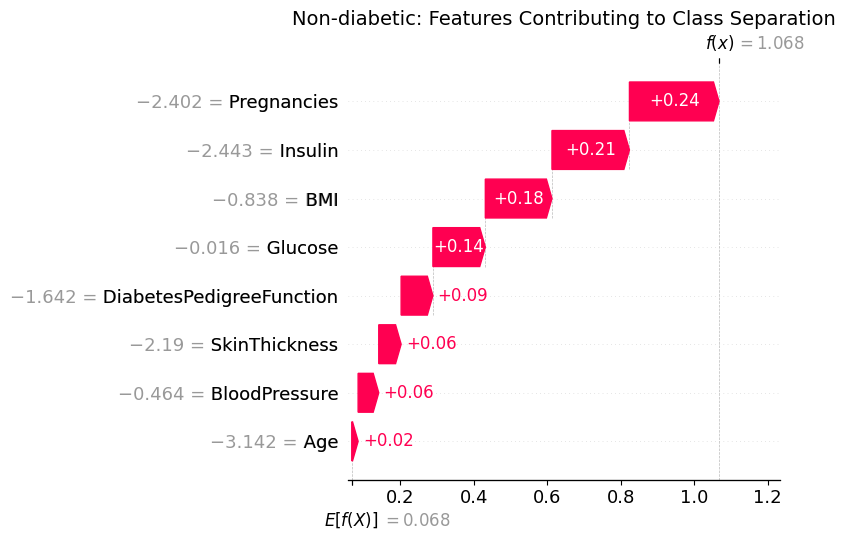

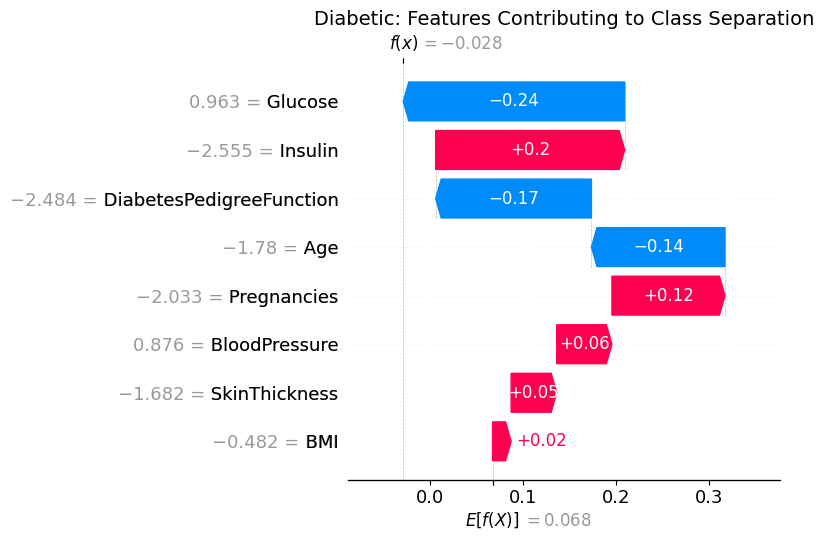

In [ ]:
shap_values_class_0, shap_values_class_1 = class_separation_shap(
    feature_map=feature_map,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    backend=backend,
    feature_names=feature_names
)

For the Diabetic waterfall graph, we can see insulin and pregnancies have strong positive contributions, meaning these features make the encoded quantum state of the sample look more like a diabetic patient. 

In contrast, glucose, diabetes pedigree function and age decrease the fidelity between the sample, meaning these features are pulling the state to be less similar to typical diabetic characteristics. This means that these features act as differentiators, helping separate diabetic states from non-diabetic states.